# East coast floods


In [1]:
import os
import datetime
import glob

from collections import Counter
import calendar
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cartopy
import cartopy.crs as ccrs
import geopandas as gp
from IPython.display import Image
from scipy.stats import genextreme as gev
import xclim as xc
import cmocean
import seaborn as sns

from unseen import fileio
from unseen import general_utils
from unseen import time_utils
from unseen import indices

In [2]:
# Optional parameters 
# (This cell is tagged "parameters")
dpi = 300

In [3]:
# Parameters
agcd_file = "/g/data/xv83/dbi599/east-coast-rain/data/Rx15day_AGCD-CSIRO_r005_1900-2022_annual-aug-to-sep_east-coast-flood-region.zarr.zip"
model_file = "/g/data/xv83/dbi599/east-coast-rain/data/Rx15day_IPSL-CM6A-LR-dcppA-hindcast_196101-201701_annual-aug-to-sep_east-coast-flood-region.zarr.zip"
model_bc_file = "/g/data/xv83/dbi599/east-coast-rain/data/Rx15day_IPSL-CM6A-LR-dcppA-hindcast_196101-201701_annual-aug-to-sep_east-coast-flood-region_bias-corrected-AGCD-CSIRO-multiplicative.zarr.zip"
similarity_bc_file = "/g/data/xv83/dbi599/east-coast-rain/data/similarity-test_Rx15day_IPSL-CM6A-LR-dcppA-hindcast_197001-201701_annual-aug-to-sep_east-coast-flood-region_bias-corrected-AGCD-CSIRO-multiplicative.zarr.zip"
similarity_raw_file = "/g/data/xv83/dbi599/east-coast-rain/data/similarity-test_Rx15day_IPSL-CM6A-LR-dcppA-hindcast_197001-201701_annual-aug-to-sep_east-coast-flood-region_AGCD-CSIRO.zarr.zip"
independence_plot = "/g/data/xv83/dbi599/east-coast-rain/figures/independence-test_Rx15day_IPSL-CM6A-LR-dcppA-hindcast_196101-201701_annual-aug-to-sep_east-coast-flood-region.png"
model_name = "IPSL-CM6A-LR"
min_lead = 0
region_name = "east-coast-flood-region"
shape_file = "/g/data/xv83/dbi599/east-coast-rain/shapefiles/east-coast-flood.shp"
file_list = "file_lists/IPSL-CM6A-LR_dcppA-hindcast_pr_files.txt"
nino_file = "/g/data/xv83/dbi599/east-coast-rain/data/nino34-anomaly_IPSL-CM6A-LR-dcppA-hindcast_196101-201701_base-197001-201701.zarr.zip"


In [4]:
# Required parameters
assert 'model_name' in locals(), "Must provide a model name"
assert 'region_name' in locals(), "Must provide a region name"
assert 'min_lead' in locals(), "Must provide a minimum lead time"
assert os.path.isfile(file_list), "Must provide the input model files list (papermill option -p file_list [filepath])"
assert os.path.isfile(shape_file), "Must provide the shapefile (papermill option -p shape_file [filepath])"
assert os.path.isfile(agcd_file), "Must provide an AGCD data file (papermill option -p agcd_file [filepath])"
assert os.path.isfile(model_file), "Must provide an model data file (papermill option -p cafe_file [filepath])"
assert os.path.isfile(model_bc_file), "Must provide a model bias corrected data file (papermill option -p cafe_bc_file [filepath])"
assert os.path.isfile(nino_file), "Must provide a model Nino 3.4 data file (papermill option -p nino_file [filepath])"
assert os.path.isfile(similarity_bc_file), "Must provide an bias corrected similarity test file (papermill option -p similarity_bias_file [filepath])"
assert os.path.isfile(similarity_raw_file), "Must provide an raw data similarity test file (papermill option -p similarity_raw_file [filepath])"
assert os.path.isfile(independence_plot), "Must provide an independence test plot (papermill option -p independence_plot [filepath])"

## Observations

In [5]:
agcd_ds = fileio.open_dataset(agcd_file)
agcd_ds = agcd_ds.dropna('time')

In [6]:
agcd_ds

<xarray.Dataset>
Dimensions:     (time: 122)
Coordinates:
    event_time  (time) <U28 dask.array<chunksize=(122,), meta=np.ndarray>
  * time        (time) object 1901-01-01 09:00:00 ... 2022-01-01 09:00:00
Data variables:
    pr          (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes: (12/33)
    CDI:                           Climate Data Interface version ?? (http://...
    CDO:                           Climate Data Operators version 1.7.0 (http...
    Conventions:                   CF-1.6
    acknowledgment:                The Australian Government, Bureau of Meteo...
    analysis_components:           total: the gridded accumulation of rainfall.
    bom-cmp-awap_version:          bom-cmp-awap-1.00-89.0.x86_64
    ...                            ...
    summary:                       The daily and monthly rainfall data repres...
    time_coverage_end:             1900-01-01T09:00:00
    time_coverage_start:           1899-12-31T09:00:00
    title:                         Interpolated Rain Gauge Precipitation
    url:                           http://www.bom.gov.au/climate/
    uuid:                          14333ae2-28fe-4cb6-9f00-677adc94f25e

In [7]:
years = agcd_ds['time'].dt.year.values
agcd_df = pd.DataFrame(index=years)
agcd_df['pr'] = agcd_ds['pr'].values

In [8]:
pr2022 = agcd_ds['pr'].values.max()
print(pr2022)

410.43057


## Model ensemble

### Region selection

In [9]:
with open(file_list) as f:
    all_files = f.read()
    first_file = all_files.split('\n', 1)[0]

In [10]:
first_file

'/g/data/oi10/replicas/CMIP6/DCPP/IPSL/IPSL-CM6A-LR/dcppA-hindcast/s1960-r1i1p1f1/day/pr/gr/v20200108/pr_day_IPSL-CM6A-LR_dcppA-hindcast_s1960-r1i1p1f1_gr_19610101-19701231.nc'

In [11]:
shapes = gp.read_file(shape_file)

In [12]:
isel_dict = {'time': 0}
if model_name == 'CAFE':
    isel_dict['ensemble'] = 0
    metadata_file = '/home/599/dbi599/unseen/config/dataset_cafe_daily.yml'
else:
    metadata_file = None

In [13]:
region_ds = fileio.open_dataset(
    first_file,
    metadata_file=metadata_file,
    variables=['pr'],
    lat_bnds=[-40, -20],
    lon_bnds=[140, 160],
    shapefile=shape_file,
    shape_overlap=0.1,
    units={'pr': 'mm day-1'},
    isel=isel_dict,
)

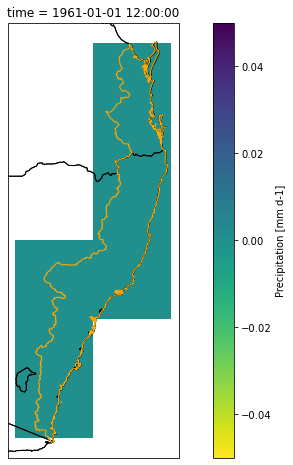

In [14]:
fig = plt.figure(figsize=[12,8])
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
region_ds['pr'].plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='viridis_r',
)
ax.coastlines()
ax.add_feature(cartopy.feature.STATES)
ax.add_geometries(shapes.geometry, ccrs.PlateCarree(), facecolor='none', edgecolor='orange')
plt.show()

### Model data

In [15]:
model_ds = fileio.open_dataset(model_file)
model_bc_ds = fileio.open_dataset(model_bc_file)

In [16]:
model_ds

<xarray.Dataset>
Dimensions:     (ensemble: 10, init_date: 57, lead_time: 11)
Coordinates:
  * ensemble    (ensemble) int64 0 1 2 3 4 5 6 7 8 9
    event_time  (init_date, ensemble, lead_time) <U28 dask.array<chunksize=(57, 10, 11), meta=np.ndarray>
  * init_date   (init_date) object 1961-01-01 00:00:00 ... 2017-01-01 00:00:00
  * lead_time   (lead_time) int64 0 1 2 3 4 5 6 7 8 9 10
    time        (lead_time, init_date) object dask.array<chunksize=(11, 57), meta=np.ndarray>
Data variables:
    pr          (init_date, ensemble, lead_time) float32 dask.array<chunksize=(1, 1, 11), meta=np.ndarray>
Attributes: (12/52)
    CMIP6_CV_version:       cv=6.2.15.1
    Conventions:            CF-1.7 CMIP-6.2
    EXPID:                  dcppA-hindcast
    NCO:                    "4.6.0"
    activity_id:            DCPP
    branch_method:          standard
    ...                     ...
    table_id:               day
    title:                  IPSL-CM6A-LR model output prepared for CMIP6 / DC...
    tracking_id:            hdl:21.14100/521eb460-8e4b-44d5-8010-e7b978713519
    variable_id:            pr
    variant_info:           Initial conditions are taken from a nudged simula...
    variant_label:          r1i1p1f1

### Independence testing

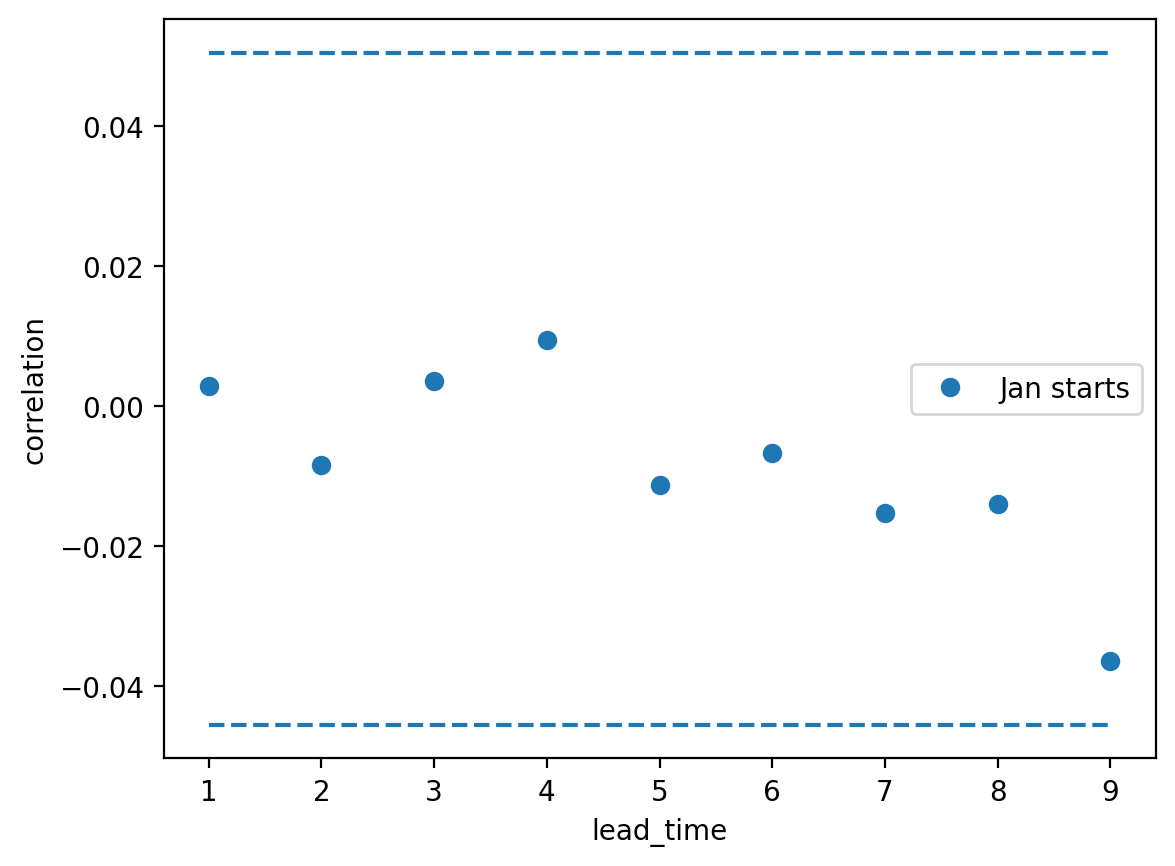

In [17]:
Image(filename=independence_plot)

In [18]:
print(min_lead)

0


In [19]:
model_da = model_ds['pr'].where(model_ds['lead_time'] >= min_lead)

In [20]:
model_da_stacked = model_da.dropna('lead_time').stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [21]:
model_da_stacked.shape

(5130,)

In [22]:
model_bc_da_stacked = model_bc_ds.dropna('lead_time')['pr'].stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [23]:
model_bc_da_stacked.shape

(5130,)

### Bias correction and similarity testing

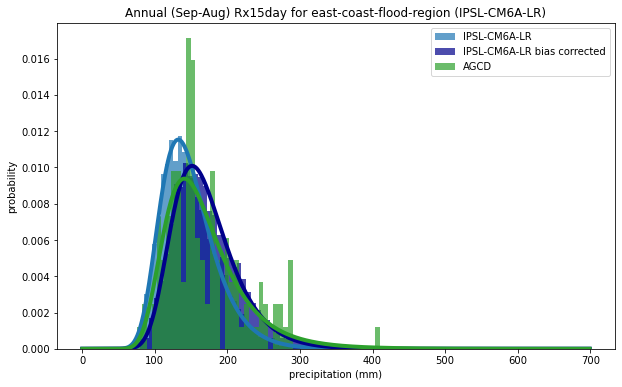

In [24]:
fig = plt.figure(figsize=[10, 6])
gev_xvals = np.arange(0, 700)

model_da.plot.hist(
    bins=50, density=True, label=model_name, alpha=0.7, facecolor='tab:blue',
)
model_gev_shape, model_gev_loc, model_gev_scale = indices.fit_gev(model_da_stacked.values)
model_gev_pdf = gev.pdf(gev_xvals, model_gev_shape, model_gev_loc, model_gev_scale)
plt.plot(gev_xvals, model_gev_pdf, color='tab:blue', linewidth=4.0)

model_bc_ds['pr'].plot.hist(
    bins=50, density=True, label=f'{model_name} bias corrected', facecolor='darkblue', alpha=0.7
)
model_bc_gev_shape, model_bc_gev_loc, model_bc_gev_scale = indices.fit_gev(model_bc_da_stacked.values)
model_bc_gev_pdf = gev.pdf(gev_xvals, model_bc_gev_shape, model_bc_gev_loc, model_bc_gev_scale)
plt.plot(gev_xvals, model_bc_gev_pdf, color='darkblue', linewidth=4.0)

agcd_ds['pr'].plot.hist(
    bins=50, density=True, label='AGCD', facecolor='tab:green', alpha=0.7
)
agcd_gev_shape, agcd_gev_loc, agcd_gev_scale = indices.fit_gev(agcd_ds['pr'].values)
agcd_gev_pdf = gev.pdf(gev_xvals, agcd_gev_shape, agcd_gev_loc, agcd_gev_scale)
plt.plot(gev_xvals, agcd_gev_pdf, color='tab:green', linewidth=4.0)

plt.xlabel('precipitation (mm)')
plt.ylabel('probability')
plt.title(f'Annual (Sep-Aug) Rx15day for {region_name} ({model_name})')
plt.legend()
plt.savefig(f'/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_histogram_{model_name}_{region_name}.png',
            bbox_inches='tight', facecolor='white', dpi=dpi)
plt.show()

We can look at p-values for the KS-test and Anderson-Darling test for each lead time.

p > 0.05 means the null hypothesis (that the two samples are from the same population) can't be rejected.

In [25]:
similarity_raw_ds = fileio.open_dataset(similarity_raw_file)

In [26]:
similarity_raw_ds['ks_pval'].values

array([0.00922422, 0.005273  , 0.00120158, 0.02590857, 0.08038007,
       0.00853096, 0.05055165, 0.02590857, 0.04740526], dtype=float32)

In [27]:
similarity_raw_ds['ad_pval'].values

array([0.001     , 0.001     , 0.001     , 0.00229913, 0.00986892,
       0.001     , 0.00696586, 0.00179628, 0.00342295], dtype=float32)

In [28]:
similarity_bias_ds = fileio.open_dataset(similarity_bc_file)

In [29]:
similarity_bias_ds['ks_pval'].values

array([0.66962093, 0.7850853 , 0.82079345, 0.64984864, 0.51418924,
       0.44209594, 0.69173646, 0.88280517, 0.6300817 ], dtype=float32)

In [30]:
similarity_bias_ds['ad_pval'].values

array([0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25],
      dtype=float32)

### Exceedance curves

In [31]:
def plot_exceedance(sample_ds, model_name, outfile=None):
    """Plot single exceedance curve"""
    
    sorted_data, exceedance_data = general_utils.exceedance_curve(sample_ds)
    
    fig = plt.figure(figsize=[8, 6])
    ax = fig.add_subplot()
    ax.plot(sorted_data, exceedance_data)
    ax.set_title(f'Annual (Sep-Aug) Rx15day for {region_name} ({model_name})')
    ax.set_ylabel('likelihood of exceedance (%)')
    ax.set_xlabel('Rx15day precipitation (mm)')
    ax.axvline(pr2022, color='0.5', linestyle='--')
    if outfile:
        plt.savefig(outfile, bbox_inches='tight', facecolor='white', dpi=dpi)
        print(outfile)
    else:
        plt.show()

In [32]:
def gev_event_likelihood(event, shape, loc, scale):
    """Get likelihood stats for an event from a GEV fit"""

    probability = gev.sf(event, shape, loc=loc, scale=scale)
    return_period = 1. / probability
    percentile = (1 - probability) * 100
    print(f'{percentile:.2f}% percentile')
    print(f'{return_period:.0f} year return period\n')

In [33]:
def plot_exceedance_by_decade(sample_ds, model_name):
    """Plot exceedance curve by decade"""

    fig = plt.figure(figsize=[8, 6])
    ax = fig.add_subplot()
    if model_name == 'CAFE':
        start_years = [1995, 2000, 2005, 2010, 2015]
        step = 4
    else:
        start_years = [1960, 1970, 1980, 1990, 2000, 2010]
        step = 9
    colors = iter(plt.cm.hot_r(np.linspace(0.3, 1, len(start_years))))

    for start_year in start_years:
        end_year = start_year + step
        start_date = f'{start_year}-01-01'
        end_date = f'{end_year}-12-25'
        ds_selection = time_utils.select_time_period(sample_ds, [start_date, end_date])
        ds_selection = ds_selection.dropna('sample')
        sorted_data, exceedance_data = general_utils.exceedance_curve(ds_selection)
        n_years = len(sorted_data)
        label = f'{start_year}-{end_year} ({n_years} samples)'
        color = next(colors)
        ax.plot(sorted_data, exceedance_data, label=label, color=color)
    
        print(f'{start_year}-{end_year}')
        n_events, n_population, return_period, percentile = general_utils.event_in_context(ds_selection.values, pr2022, 'above')
        print(f'{n_events} events in {n_population} samples')
        print(f'{percentile:.2f}% percentile')
        print(f'{return_period:.0f} year return period')
        print('GEV:')
        gev_shape, gev_loc, gev_scale = indices.fit_gev(ds_selection.values)
        gev_event_likelihood(pr2022, gev_shape, gev_loc, gev_scale)

    ax.set_title(f'Annual (Sep-Aug) Rx15day for {region_name} ({model_name})')
    ax.set_ylabel('likelihood of exceedance (%)')
    ax.set_xlabel('Rx15day precipitation (mm)')
    ax.legend()
    ax.axvline(pr2022, color='0.5', linestyle='--')
    outfile = f'/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_precip_exceedence_{region_name}_{model_name}_by-decade.png'
    plt.savefig(outfile, bbox_inches='tight', facecolor='white', dpi=dpi)
    print(outfile)

#### Bias corrected data

/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_precip_exceedence_east-coast-flood-region_IPSL-CM6A-LR.png


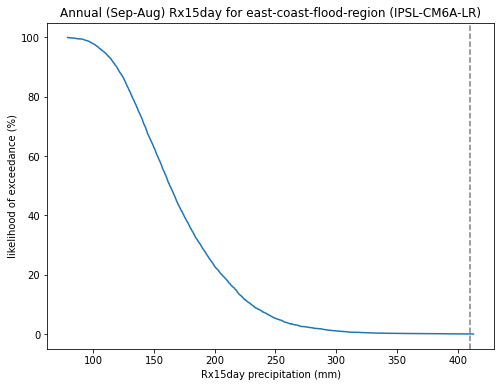

In [34]:
outfile = f'/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_precip_exceedence_{region_name}_{model_name}.png'
plot_exceedance(model_bc_da_stacked, model_name, outfile=outfile)

In [35]:
n_events_bc, n_population_bc, return_period_bc, percentile_bc = general_utils.event_in_context(model_bc_da_stacked.values, pr2022, 'above')
print('BIAS CORRECTED DATA')
print(f'{n_events_bc} events in {n_population_bc} samples')
print(f'{percentile_bc:.2f}% percentile')
print(f'{return_period_bc:.0f} year return period')

BIAS CORRECTED DATA
1 events in 5130 samples
99.98% percentile
5130 year return period


In [36]:
print('BIAS CORRECTED GEV')
gev_event_likelihood(pr2022, model_bc_gev_shape, model_bc_gev_loc, model_bc_gev_scale)

BIAS CORRECTED GEV
99.97% percentile
3324 year return period



1960-1969
0 events in 360 samples
100.00% percentile
inf year return period
GEV:


/home/599/dbi599/unseen/unseen/general_utils.py:151: RuntimeWarning: divide by zero encountered in long_scalars
  return_period = n_population / n_events


99.99% percentile
8932 year return period

1970-1979


/home/599/dbi599/unseen/unseen/general_utils.py:151: RuntimeWarning: divide by zero encountered in long_scalars
  return_period = n_population / n_events


0 events in 880 samples
100.00% percentile
inf year return period
GEV:
99.98% percentile
6239 year return period

1980-1989


/home/599/dbi599/unseen/unseen/general_utils.py:151: RuntimeWarning: divide by zero encountered in long_scalars
  return_period = n_population / n_events


0 events in 900 samples
100.00% percentile
inf year return period
GEV:
99.98% percentile
5376 year return period

1990-1999


/home/599/dbi599/unseen/unseen/general_utils.py:151: RuntimeWarning: divide by zero encountered in long_scalars
  return_period = n_population / n_events


0 events in 880 samples
100.00% percentile
inf year return period
GEV:
99.94% percentile
1575 year return period

2000-2009


/home/599/dbi599/unseen/unseen/general_utils.py:151: RuntimeWarning: divide by zero encountered in long_scalars
  return_period = n_population / n_events


0 events in 900 samples
100.00% percentile
inf year return period
GEV:
99.94% percentile
1675 year return period

2010-2019


/home/599/dbi599/unseen/unseen/general_utils.py:151: RuntimeWarning: divide by zero encountered in long_scalars
  return_period = n_population / n_events


0 events in 870 samples
100.00% percentile
inf year return period
GEV:
99.98% percentile
4684 year return period

/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_precip_exceedence_east-coast-flood-region_IPSL-CM6A-LR_by-decade.png


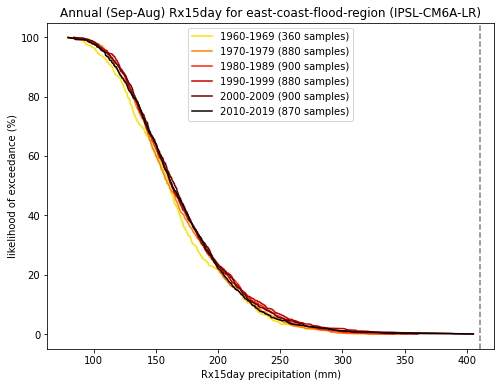

In [37]:
plot_exceedance_by_decade(model_bc_da_stacked, model_name)

#### Raw data

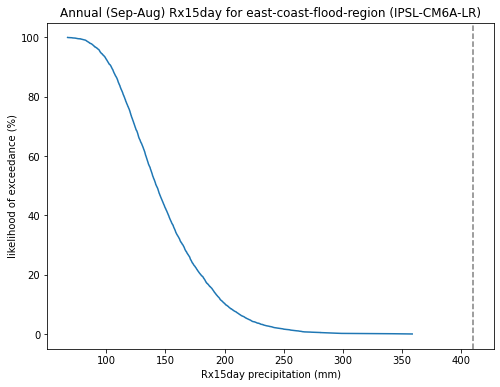

In [38]:
plot_exceedance(model_da_stacked, model_name)

In [39]:
n_events, n_population, return_period, percentile = general_utils.event_in_context(model_da_stacked.values, pr2022, 'above')
print('RAW DATA')
print(f'{n_events} events in {n_population} samples')
print(f'{percentile:.2f}% percentile')
print(f'{return_period:.0f} year return period')

RAW DATA
0 events in 5130 samples
100.00% percentile
inf year return period


/home/599/dbi599/unseen/unseen/general_utils.py:151: RuntimeWarning: divide by zero encountered in long_scalars
  return_period = n_population / n_events


In [40]:
print('RAW GEV')
gev_event_likelihood(pr2022, model_gev_shape, model_gev_loc, model_gev_scale)

RAW GEV
100.00% percentile
29397 year return period



### Seasonality

In [41]:
model_df = model_da_stacked.to_dataframe()
model_df = model_df.dropna()
model_df = model_df.reset_index()
model_df

,ensemble,init_date,lead_time,event_time,time,pr
0,0,1961-01-01 00:00:00,1,1962-08-26,1962-01-01 12:00:00,144.171402
1,0,1961-01-01 00:00:00,2,1963-03-22,1963-01-01 12:00:00,173.555908
2,0,1961-01-01 00:00:00,3,1963-12-29,1964-01-02 12:00:00,135.087906
3,0,1961-01-01 00:00:00,4,1965-06-17,1965-01-01 12:00:00,116.160988
4,0,1961-01-01 00:00:00,5,1966-02-21,1966-01-01 12:00:00,166.734695
...,...,...,...,...,...,...
5125,9,2017-01-01 00:00:00,5,2022-08-23,2022-01-01 12:00:00,79.540703
5126,9,2017-01-01 00:00:00,6,2023-03-01,2023-01-01 12:00:00,199.877945
5127,9,2017-01-01 00:00:00,7,2024-02-21,2024-01-02 12:00:00,166.873764
5128,9,2017-01-01 00:00:00,8,2025-02-08,2025-01-01 12:00:00,168.771194


In [42]:
event_months = [int(date[5:7]) for date in model_df['event_time'].values]
event_years = [int(date[0:4]) for date in model_df['event_time'].values]

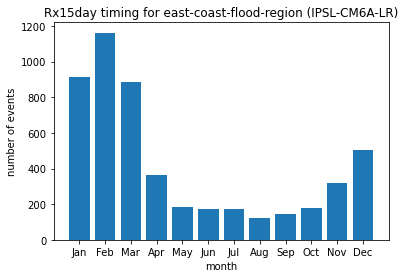

In [43]:
month_counts = Counter(event_months)
months = np.arange(1, 13)
counts = [month_counts[month] for month in months]

plt.bar(months, counts)
plt.title(f'Rx15day timing for {region_name} ({model_name})')
plt.ylabel('number of events')
plt.xlabel('month')
xlabels = [calendar.month_abbr[i] for i in months]
plt.xticks(months, xlabels)
#plt.savefig(
#    f'/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_timing_AGCD_{region_name}.png',
#    bbox_inches='tight',
#    facecolor='white',
#    dpi=dpi
#)
plt.show()

### Relationship with ENSO

In [44]:
nino_ds = fileio.open_dataset(nino_file)
nino_ds = nino_ds.assign_coords({'init_date': [date.strftime('%Y%m') for date in nino_ds['init_date'].values]})
nino_ds

<xarray.Dataset>
Dimensions:    (ensemble: 10, init_date: 57, lead_time: 120)
Coordinates:
  * ensemble   (ensemble) int64 0 1 2 3 4 5 6 7 8 9
  * init_date  (init_date) <U6 '196101' '196201' '196301' ... '201601' '201701'
  * lead_time  (lead_time) int64 0 1 2 3 4 5 6 7 ... 113 114 115 116 117 118 119
    time       (lead_time, init_date) object dask.array<chunksize=(120, 57), meta=np.ndarray>
Data variables:
    tos        (init_date, ensemble, lead_time) float32 dask.array<chunksize=(1, 1, 120), meta=np.ndarray>
Attributes:
    history:  Fri Feb 03 11:26:53 2023: /g/data/xv83/dbi599/miniconda3/envs/u...

In [45]:
nino_values = []
for index, row in model_df.iterrows():
    event_init_date = row['init_date'].strftime('%Y%m')
    event_ensemble = row['ensemble']
    event_year_month = row['time'].strftime('%Y-%m')
    nino_selection = nino_ds.sel({'init_date': event_init_date, 'ensemble': event_ensemble})
    nino_selection = nino_selection.swap_dims({'lead_time': 'time'})
    nino_year_month = [date.strftime('%Y-%m') for date in nino_selection['time'].values]
    nino_selection = nino_selection.assign_coords({'time': nino_year_month})
    nino_value = float(nino_selection['tos'].sel({'time': event_year_month}).values)
    nino_values.append(nino_value)

In [46]:
model_df['nino34'] = nino_values

/g/data/xv83/dbi599/miniconda3/envs/unseen/lib/python3.9/site-packages/seaborn/distributions.py:1182: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(


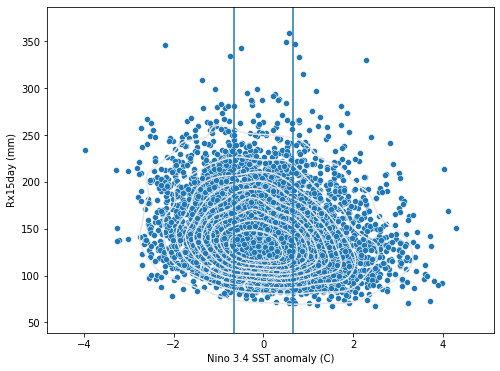

In [47]:
fig = plt.figure(figsize=[8, 6])
ax = fig.add_subplot(111)

sns.scatterplot(ax=ax, data=model_df, x='nino34', y='pr')
sns.kdeplot(ax=ax, data=model_df, x='nino34', y='pr', color='0.9', linewidth=1)

ax.set_ylabel('Rx15day (mm)')
ax.set_xlabel('Nino 3.4 SST anomaly (C)')
ax.axvline(0.65)
ax.axvline(-0.65)
plt.show()

### Meteorology

In [62]:
def plot_average(start_date, end_date, color_da=None, color_var=None, contour_da=None, contour_var=None):
    """Plot average"""
    
    fig = plt.figure(figsize=[10, 5])
    map_proj=ccrs.PlateCarree(central_longitude=180)
    ax1 = fig.add_subplot(1, 1, 1, projection=map_proj)       
    
    if color_var:
        if color_var == 'pr':
            levels = [0, 100, 200, 300, 400, 500, 600, 700, 800]
            label = 'total precipitation (mm)'
            cmap = cmocean.cm.rain
            extend = 'max'
        elif color_var == 'ua300':
            levels = [-30, -25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25, 30]
            label = '300hPa zonal wind'
            cmap='RdBu_r'
            extend = 'both'
        else:
            raise ValueError('Invalid color variable')
        color_da.plot(
            ax=ax1,
            transform=ccrs.PlateCarree(),
            cmap=cmap,
            levels=levels,
            extend=extend,
            cbar_kwargs={'label': label},
        )
    
    if contour_var:
        if contour_var == 'z500':
            levels = np.arange(5000, 6300, 50)
        elif contour_var == 'psl':
            levels = np.arange(900, 1100, 2.5)
        elif contour_var == 'ua300':
            levels = np.arange(15, 60, 5)
        else:
            raise ValueError('Invalid contour variable')
        lines = contour_da.plot.contour(
            ax=ax1,
            transform=ccrs.PlateCarree(),
            levels=levels,
            colors=['0.1']
        )
        ax1.clabel(lines, colors=['0.1'], manual=False, inline=True)
    
    ax1.coastlines()
    ax1.set_extent([90, 205, -55, 10], crs=ccrs.PlateCarree())
    ax1.gridlines(linestyle='--', draw_labels=True)
    if contour_var:
        ax1.set_title(f'Average {contour_var} ({contour_da.units}), {start_date} to {end_date}')
    else:
        ax1.set_title(f'{start_date} to {end_date}')
#    plt.savefig(
#        f'/home/599/dbi599/east-coast-rain/{color_var}-{contour_var}_mean_BARRA2_{start_date}_{end_date}.png',
#        bbox_inches='tight',
#        facecolor='white',
#        dpi=300
#    )
    plt.show()

In [49]:
ranked_events = model_df.sort_values(by=['pr'], ascending=False)
ranked_events.head(n=10)

,ensemble,init_date,lead_time,event_time,time,pr,nino34
1533,2,2017-01-01 00:00:00,4,2021-01-31,2021-01-01 12:00:00,358.673645,0.563211
1463,2,2009-01-01 00:00:00,6,2015-02-27,2015-01-01 12:00:00,349.691162,0.509136
2922,5,2000-01-01 00:00:00,7,2007-02-01,2006-12-31 12:00:00,346.728851,0.707460
3917,7,1997-01-01 00:00:00,3,2000-02-06,2000-01-02 12:00:00,345.793549,-2.191414
1005,1,2015-01-01 00:00:00,7,2022-02-08,2022-01-01 12:00:00,342.753662,-0.491863
2448,4,2005-01-01 00:00:00,1,2006-02-07,2006-01-01 12:00:00,334.572693,-0.753191
1491,2,2012-01-01 00:00:00,7,2019-02-15,2018-12-31 12:00:00,332.911133,0.799831
2904,5,1998-01-01 00:00:00,7,2005-03-01,2005-01-01 12:00:00,329.880463,2.279247
1294,2,1990-01-01 00:00:00,8,1998-01-07,1998-01-01 12:00:00,315.436249,0.884138
3175,6,1971-01-01 00:00:00,8,1979-02-13,1979-01-01 12:00:00,308.476440,-1.376310


In [50]:
model_bc_df = model_bc_ds['pr'].to_dataframe()
model_bc_df = model_bc_df.dropna()
model_bc_df = model_bc_df.reset_index()
ranked_bc_events = model_bc_df.sort_values(by=['pr'], ascending=False)
ranked_bc_events.head(n=10)

,init_date,ensemble,lead_time,event_time,time,pr
5061,2017-01-01 00:00:00,2,4,2021-01-31,2021-01-01 12:00:00,412.929413
3305,1997-01-01 00:00:00,7,3,2000-02-06,2000-01-02 12:00:00,405.375793
4343,2009-01-01 00:00:00,2,6,2015-02-27,2015-01-01 12:00:00,405.241516
3561,2000-01-01 00:00:00,5,7,2007-02-01,2006-12-31 12:00:00,389.984924
3996,2005-01-01 00:00:00,4,1,2006-02-07,2006-01-01 12:00:00,387.174164
4875,2015-01-01 00:00:00,1,7,2022-02-08,2022-01-01 12:00:00,385.513824
4614,2012-01-01 00:00:00,2,7,2019-02-15,2018-12-31 12:00:00,374.443390
3381,1998-01-01 00:00:00,5,7,2005-03-01,2005-01-01 12:00:00,371.034637
2635,1990-01-01 00:00:00,2,8,1998-01-07,1998-01-01 12:00:00,360.559937
961,1971-01-01 00:00:00,6,8,1979-02-13,1979-01-01 12:00:00,352.604492


2016 (2021-01-31), ensemble: r3, 358.67364501953125mm
['/g/data/oi10/replicas/CMIP6/DCPP/IPSL/IPSL-CM6A-LR/dcppA-hindcast/s2016-r3i1p1f1/day/pr/gr/v20200108/pr_day_IPSL-CM6A-LR_dcppA-hindcast_s2016-r3i1p1f1_gr_20170101-20261231.nc']


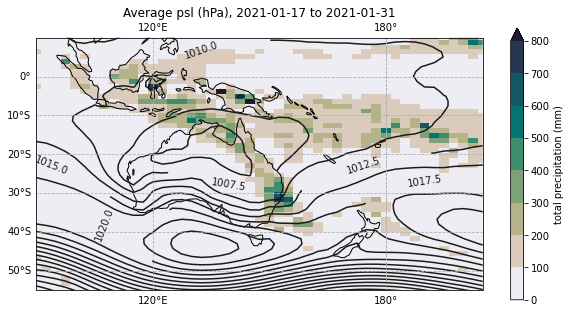

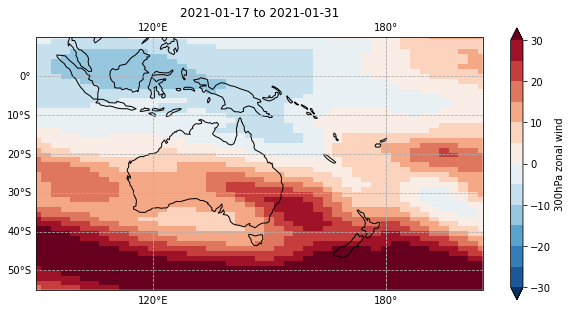

2008 (2015-02-27), ensemble: r3, 349.691162109375mm
['/g/data/oi10/replicas/CMIP6/DCPP/IPSL/IPSL-CM6A-LR/dcppA-hindcast/s2008-r3i1p1f1/day/pr/gr/v20200108/pr_day_IPSL-CM6A-LR_dcppA-hindcast_s2008-r3i1p1f1_gr_20090101-20181231.nc']


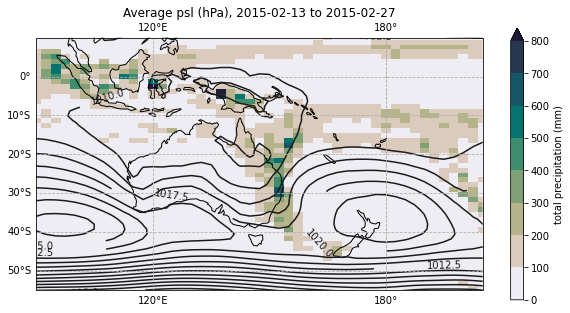

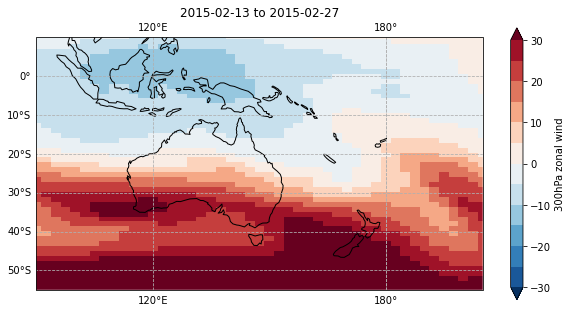

1999 (2007-02-01), ensemble: r6, 346.7288513183594mm
['/g/data/oi10/replicas/CMIP6/DCPP/IPSL/IPSL-CM6A-LR/dcppA-hindcast/s1999-r6i1p1f1/day/pr/gr/v20200108/pr_day_IPSL-CM6A-LR_dcppA-hindcast_s1999-r6i1p1f1_gr_20000101-20091231.nc']


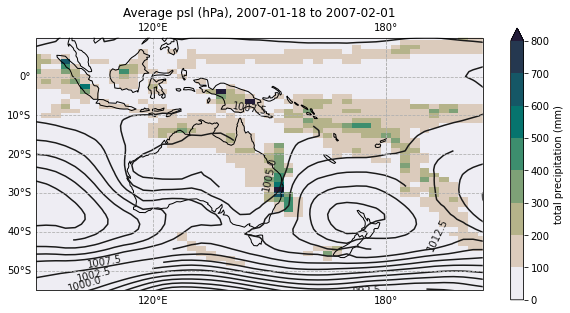

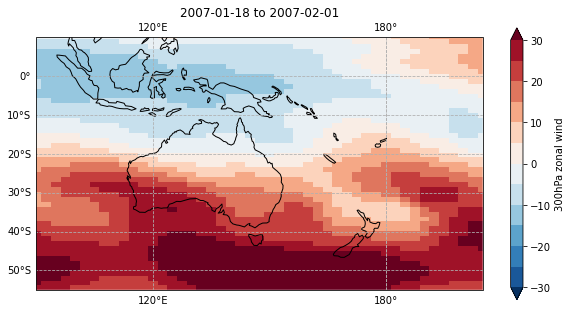

1996 (2000-02-06), ensemble: r8, 345.7935485839844mm
['/g/data/oi10/replicas/CMIP6/DCPP/IPSL/IPSL-CM6A-LR/dcppA-hindcast/s1996-r8i1p1f1/day/pr/gr/v20200108/pr_day_IPSL-CM6A-LR_dcppA-hindcast_s1996-r8i1p1f1_gr_19970101-20061231.nc']


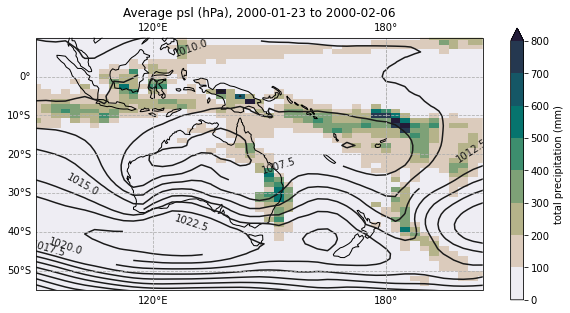

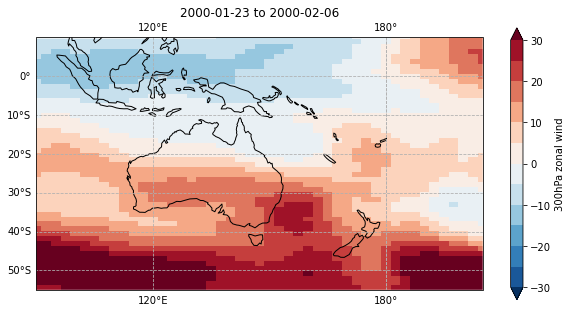

In [63]:
for index, row in ranked_events.head(n=4).iterrows():
    init_date = int(row['init_date'].strftime('%Y')) - 1
    ensemble = int(row['ensemble']) + 1
    end_date = row['event_time']
    rx_value = row['pr']
    print(f'{init_date} ({end_date}), ensemble: r{ensemble}, {rx_value}mm')
    
    start_datetime = datetime.datetime.strptime(end_date, "%Y-%m-%d") - datetime.timedelta(days=14)
    start_date = start_datetime.strftime("%Y-%m-%d")

    pr_files = glob.glob(f'/g/data/oi10/replicas/CMIP6/DCPP/*/{model_name}/dcppA-hindcast/s{init_date}-r{ensemble}i1p1f1/day/pr/*/*/*.nc')
    pr_files.sort()
    print(pr_files)
    ds_pr = fileio.open_dataset(pr_files, variables=['pr'],)
    
    psl_files = glob.glob(f'/g/data/oi10/replicas/CMIP6/DCPP/*/{model_name}/dcppA-hindcast/s{init_date}-r{ensemble}i1p1f1/day/psl/*/*/*.nc')
    psl_files.sort()
    ds_psl = fileio.open_dataset(psl_files, variables=['psl'],)
    
#    zg_files = glob.glob(f'/g/data/oi10/replicas/CMIP6/DCPP/*/{model_name}/dcppA-hindcast/s{init_date}-r{ensemble}i1p1f1/day/zg/*/*/*.nc')
#    zg_files.sort()
#    ds_zg = fileio.open_dataset(zg_files, variables=['zg'],)
    
    ua_files = glob.glob(f'/g/data/oi10/replicas/CMIP6/DCPP/*/{model_name}/dcppA-hindcast/s{init_date}-r{ensemble}i1p1f1/day/ua/*/*/*.nc')
    ua_files.sort()
    ds_ua = fileio.open_dataset(ua_files, variables=['ua'],)

    pr_da = ds_pr.sel({'time': slice(start_date, end_date)})['pr']
    pr_da = xc.units.convert_units_to(pr_da, 'mm d-1')
    psl_da = ds_psl.sel({'time': slice(start_date, end_date)})['psl']
    psl_da = xc.units.convert_units_to(psl_da, 'hPa')
#    zg_da = ds_zg.sel({'time': slice(start_date, end_date)})['zg']
#    z500_da = zg_da.sel({'plev': 50000}, method='nearest')
    ua_da = ds_ua.sel({'time': slice(start_date, end_date)})['ua']
    ua300_da = ua_da.sel({'plev': 30000}, method='nearest')

    pr_da_sum = pr_da.sum('time', keep_attrs=True)
    psl_da_mean = psl_da.mean('time', keep_attrs=True)
#    z500_da_mean = z500_da.mean('time', keep_attrs=True)
    ua300_da_mean = ua300_da.mean('time', keep_attrs=True) 

    plot_average(start_date, end_date, pr_da_sum, 'pr', psl_da_mean, 'psl')
#    plot_average(start_date, end_date, pr_da_sum, 'pr', z500_da_mean, 'z500')
    plot_average(start_date, end_date, ua300_da_mean, 'ua300')